In [46]:
! git clone https://github.com/intsystems/bmm-multitask-learning.git

Cloning into 'bmm-multitask-learning'...
remote: Enumerating objects: 686, done.
remote: Counting objects: 100% (315/315), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 686 (delta 123), reused 235 (delta 89), pack-reused 371 (from 1)
Receiving objects: 100% (686/686), 6.91 MiB | 26.50 MiB/s, done.
Resolving deltas: 100% (268/268), done.


In [ ]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.special import softmax

In [2]:
import os, sys
#sys.path.append("..")
#sys.path.insert(1, "/kaggle/input/multitask")
sys.path.append("..")
sys.path.append("bmm-multitask-learning/bmm_multitask_learning/task_clustering")

In [3]:
n_input = 5
n_hidden = 4  
n_tasks = 10
n_clusters = 2
n_features = 3
n_samples = 200

# Neural Network Model

In [4]:
from MultiTask_Algo import MultiTaskNN

In [5]:
def generate_synthetic_data(n_tasks=10, n_samples_train=50, n_samples_test=300,
                            n_input=5, n_hidden=4, activation='tanh'):
    # True parameters
    true_W = np.random.randn(n_hidden, n_input + 1)
    true_Sigma = np.eye(n_hidden + 1) * 0.5
    true_m = np.array([0.1, 1.5, -1.5, 2, 4])

    # Generate data for each task
    train_data = []
    test_data = []

    for i in range(n_tasks):
        # Generate covariates
        X_train = np.random.randn(n_samples_train, n_input)
        X_test = np.random.randn(n_samples_test, n_input)

        # Scale per task to zero mean and unit variance
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Compute hidden activations
        X_train_bias = np.hstack([X_train, np.ones((n_samples_train, 1))])
        X_test_bias = np.hstack([X_test, np.ones((n_samples_test, 1))])

        if activation == 'tanh':
            h_train = np.tanh(np.dot(X_train_bias, true_W.T))
            h_test = np.tanh(np.dot(X_test_bias, true_W.T))
        else:
            h_train = np.dot(X_train_bias, true_W.T)
            h_test = np.dot(X_test_bias, true_W.T)

        # Add bias term
        h_train = np.hstack([h_train, np.ones((n_samples_train, 1))])
        h_test = np.hstack([h_test, np.ones((n_samples_test, 1))])

        # Generate task-specific weights from true distribution
        A = np.random.multivariate_normal(true_m, true_Sigma)

        # Generate responses with noise
        y_train = np.dot(h_train, A) + np.random.randn(n_samples_train) * 0.1
        y_test = np.dot(h_test, A) + np.random.randn(n_samples_test) * 0.1

        train_data.append((X_train, y_train))
        test_data.append((X_test, y_test))

    return train_data, test_data

In [6]:
def evaluate_model(model, test_data):
    mse = 0
    for i, (X_test, y_test) in enumerate(test_data):
        y_pred = model.predict(X_test, i)
        mse += np.mean((y_test - y_pred) ** 2)
    mse /= len(test_data)

    return {'test_mse': mse}

In [7]:
def plot_training_results(model, X_list, y_list):
    plt.figure(figsize=(18, 12))
    
    # 1. График предсказаний vs истинных значений (первые 3 задачи)
    plt.subplot(2, 3, 1)
    
    global_min = min(np.min(y) for y in y_list)
    global_max = max(np.max(y) for y in y_list)

    for i in range(min(3, len(X_list))):
        y_pred = model.predict(X_list[i], i)
        plt.scatter(y_list[i], y_pred, alpha=0.6, label=f'Task {i+1}')
    plt.plot([global_min, global_max], [global_min, global_max], 'k--', label='Ideal')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Predictions vs True Values (Train)')
    plt.legend()

    # 2. MSE по задачам
    #plt.subplot(2, 3, 2)
    #train_mses = []
    #for i, (X, y) in enumerate(zip(X_list, y_list)):
    #    y_pred = model.predict(X, i)
    #    train_mses.append(mean_squared_error(y, y_pred))
    #plt.bar(range(1, len(train_mses)+1), train_mses)
    #plt.xlabel('Task')
    #plt.ylabel('MSE')
    #plt.title('Train MSE per Task')
    
    # 3. Визуализация весов W
    #plt.subplot(2, 3, 3)
    #plt.imshow(model.W, aspect='auto', cmap='coolwarm')
    #plt.colorbar()
    #plt.title('Shared Weights W')
    
    # 4. Визуализация весов A (первые 10 задач)
    #plt.subplot(2, 3, 4)
    #A_matrix = np.array(model.A_map[:10])  # Покажем только первые 10 задач
    #plt.imshow(A_matrix, aspect='auto', cmap='coolwarm')
    #plt.colorbar()
    #plt.title('Task-specific Weights A (first 10 tasks)')
    
    plt.tight_layout()
    plt.show()

In [8]:
def run_simulations(n_simulations=1, activation='tanh', with_plot=False,
                    n_tasks=10, n_input=5, n_hidden=4):
    results = []
    successful_simulations = 0

    for sim in range(n_simulations):
        print(f"\nSimulation {sim + 1}/{n_simulations}")

        try:
            # Generate data
            train_data, test_data = generate_synthetic_data(
                n_tasks=n_tasks, n_input=n_input,
                n_hidden=n_hidden, activation=activation
            )

            # Initialize and fit model
            model = MultiTaskNN(
                n_input=n_input,
                n_hidden=n_hidden,
                n_tasks=n_tasks,
                activation=activation
            )

            X_list = [X for X, y in train_data]
            y_list = [y for X, y in train_data]

            # Fit model with error handling
            fit_result = model.fit(X_list, y_list, max_iter=100)
            if fit_result is None:
                print("Skipping simulation due to fitting error")
                continue

            # Evaluate
            metrics = evaluate_model(model, test_data)
            results.append(metrics)
            successful_simulations += 1

            print(f"Test MSE: {metrics['test_mse']:.4f}")

            if with_plot:
                plot_training_results(model, X_list, y_list)

        except Exception as e:
            print(f"Error in simulation {sim + 1}: {str(e)}")
            continue

    if successful_simulations == 0:
        print("Warning: All simulations failed")
        return None

    # Aggregate results
    avg_results = {
        'avg_test_mse': np.mean([r['test_mse'] for r in results]),
        'success_rate': successful_simulations / n_simulations
    }

    return avg_results


Simulation 1/1
Test MSE: 2.0930


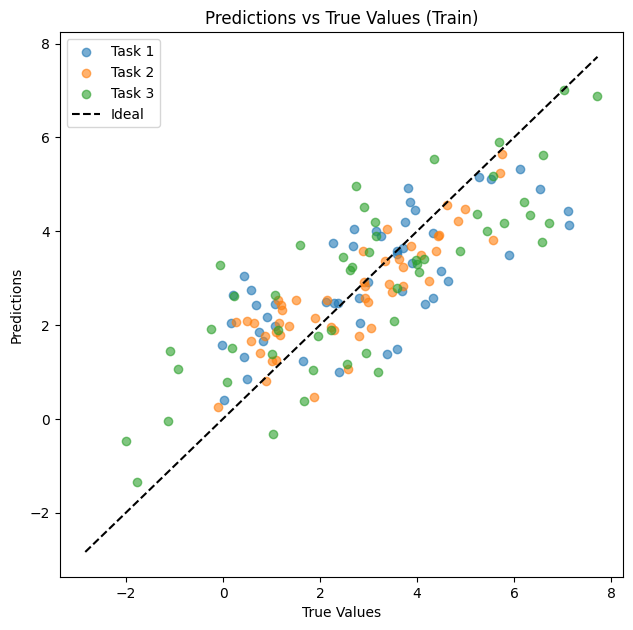

Tanh results: {'avg_test_mse': 2.0930355204737965, 'success_rate': 1.0}


In [9]:
tanh_results = run_simulations(n_simulations=1, activation='tanh', with_plot=True)
print(f"Tanh results: {tanh_results}")


Simulation 1/1
Test MSE: 14.5215


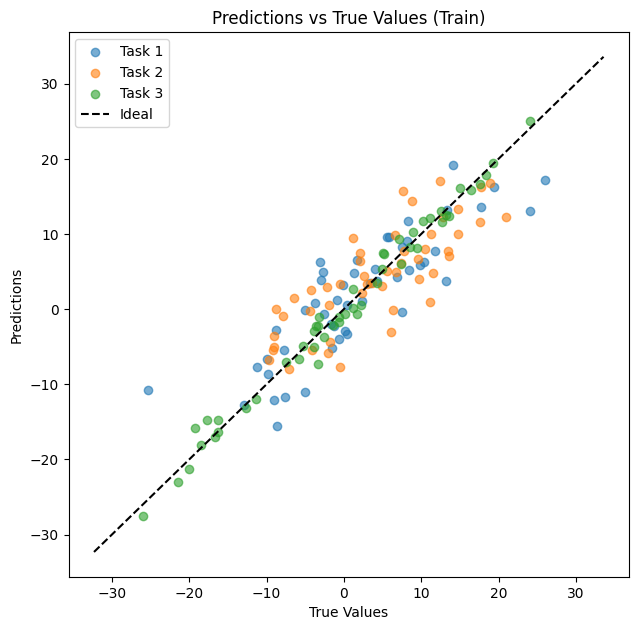

linear results: {'avg_test_mse': 14.521458949433477, 'success_rate': 1.0}


In [10]:
linear_results = run_simulations(n_simulations=1, activation='linear', with_plot=True)
print(f"linear results: {linear_results}")

# Task-dependent Prior Mean

In [11]:
from MultiTask_Algo import MultiTaskNNDependentMean

In [12]:
def generate_synthetic_data(n_tasks=10, n_samples_train=50, n_samples_test=300,
                            n_input=5, n_hidden=4, n_features=3, activation='tanh'):
    # True parameters
    true_W = np.random.randn(n_hidden, n_input + 1)
    true_Sigma = np.eye(n_hidden + 1) * 0.5
    true_M = np.random.randn(n_hidden + 1, n_features) * 0.5

    # Generate random features for each task
    task_features = np.random.randn(n_tasks, n_features)

    # Generate data for each task
    train_data = []
    test_data = []

    for i in range(n_tasks):
        # Generate covariates
        X_train = np.random.randn(n_samples_train, n_input)
        X_test = np.random.randn(n_samples_test, n_input)

        # Scale per task to zero mean and unit variance
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Compute hidden activations
        X_train_bias = np.hstack([X_train, np.ones((n_samples_train, 1))])
        X_test_bias = np.hstack([X_test, np.ones((n_samples_test, 1))])

        if activation == 'tanh':
            h_train = np.tanh(np.dot(X_train_bias, true_W.T))
            h_test = np.tanh(np.dot(X_test_bias, true_W.T))
        else:
            h_train = np.dot(X_train_bias, true_W.T)
            h_test = np.dot(X_test_bias, true_W.T)

        # Add bias term
        h_train = np.hstack([h_train, np.ones((n_samples_train, 1))])
        h_test = np.hstack([h_test, np.ones((n_samples_test, 1))])

        # Compute task-specific mean
        m_i = np.dot(true_M, task_features[i])

        # Generate task-specific weights from distribution with task-dependent mean
        A = np.random.multivariate_normal(m_i, true_Sigma)

        # Generate responses with noise
        y_train = np.dot(h_train, A) + np.random.randn(n_samples_train) * 0.1
        y_test = np.dot(h_test, A) + np.random.randn(n_samples_test) * 0.1

        train_data.append((X_train, y_train))
        test_data.append((X_test, y_test))

    return train_data, test_data, task_features

In [13]:
def evaluate_model(model, test_data, task_features):
    mse = 0
    for i, (X_test, y_test) in enumerate(test_data):
        y_pred = model.predict(X_test, i)
        mse += np.mean((y_test - y_pred) ** 2)
    mse /= len(test_data)

    return {
        'test_mse': mse,
        'task_features': task_features
    }

In [14]:
def plot_training_results(model, X_list, y_list, task_features):
    plt.figure(figsize=(20, 12))
    
    # 1. График предсказаний vs истинных значений (первые 3 задачи)
    plt.subplot(2, 3, 1)
    
    global_min = min(np.min(y) for y in y_list)
    global_max = max(np.max(y) for y in y_list)

    for i in range(min(3, len(X_list))):
        y_pred = model.predict(X_list[i], i)
        plt.scatter(y_list[i], y_pred, alpha=0.6, label=f'Task {i+1}')
    plt.plot([global_min, global_max], [global_min, global_max], 'k--', label='Ideal')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Predictions vs True Values (Train)')
    plt.legend()

    # 2. MSE по задачам
    #plt.subplot(2, 3, 2)
    #train_mses = []
    #for i, (X, y) in enumerate(zip(X_list, y_list)):
    #    y_pred = model.predict(X, i)
    #    train_mses.append(mean_squared_error(y, y_pred))
    #plt.bar(range(1, len(train_mses)+1), train_mses)
    #plt.xlabel('Task')
    #plt.ylabel('MSE')
    #plt.title('Train MSE per Task')
    
    # 3. Визуализация весов W
    #plt.subplot(2, 3, 3)
    #plt.imshow(model.W, aspect='auto', cmap='coolwarm')
    #plt.colorbar()
    #plt.title('Shared Weights W')

    # 4. Визуализация весов A (первые 10 задач)
    #plt.subplot(2, 3, 4)
    #A_matrix = np.array(model.A_map[:10])  # Покажем только первые 10 задач
    #plt.imshow(A_matrix, aspect='auto', cmap='coolwarm')
    #plt.colorbar()
    #plt.title('Task-specific Weights A (first 10 tasks)')
    
    # 5. Визуализация матрицы M
    #plt.subplot(2, 3, 5)
    #plt.imshow(model.M, aspect='auto', cmap='coolwarm')
    #plt.colorbar()
    #plt.title('Feature Weight Matrix M')

    # 6. Визуализация связей между features и весами
    #plt.subplot(2, 3, 6)
    #for i in range(min(10, len(model.A_map))):
    #    # Проверяем совпадение размерностей
    #    if len(task_features[i]) == len(model.A_map[i]):
    #        plt.scatter(task_features[i], model.A_map[i], alpha=0.6, label=f'Task {i+1}')
    #    else:
    #        # Если размерности не совпадают, строим для первых n_features весов
    #        n = min(len(task_features[i]), len(model.A_map[i]))
    #        plt.scatter(task_features[i][:n], model.A_map[i][:n], alpha=0.6, label=f'Task {i+1}')
    #plt.xlabel('Task Features')
    #plt.ylabel('A weights')
    #plt.title('Task Features vs A Weights')
    #plt.legend()
    
    plt.tight_layout()
    plt.show()

In [15]:
def run_simulations(n_simulations=1, activation='tanh', with_plot=False, 
                   n_tasks=10, n_input=5, n_hidden=4, n_features=3):
    results = []
    successful_simulations = 0
    
    for sim in range(n_simulations):
        print(f"\nSimulation {sim+1}/{n_simulations}")
        
        try:
            # Generate data with task features
            train_data, test_data, task_features = generate_synthetic_data(
                n_tasks=n_tasks, n_input=n_input, n_hidden=n_hidden,
                n_features=n_features, activation=activation
            )

            # Initialize and fit model
            model = MultiTaskNNDependentMean(
                n_input=n_input,
                n_hidden=n_hidden,
                n_tasks=n_tasks,
                n_features=n_features,
                activation=activation
            )

            X_list = [X for X, y in train_data]
            y_list = [y for X, y in train_data]
            
            # Fit model with error handling
            fit_result = model.fit(X_list, y_list, task_features, max_iter=100)
            if fit_result is None:
                print("Skipping simulation due to fitting error")
                continue

            # Evaluate
            metrics = evaluate_model(model, test_data, task_features)
            results.append(metrics)
            successful_simulations += 1
            
            print(f"Test MSE: {metrics['test_mse']:.4f}")

            if with_plot:
                try:
                    plot_training_results(model, X_list, y_list, task_features)
                except Exception as e:
                    print(f"Plotting error: {str(e)}")
                    continue
            
        except Exception as e:
            print(f"Error in simulation {sim+1}: {str(e)}")
            continue
    
    if successful_simulations == 0:
        print("Warning: All simulations failed")
        return None

    # Aggregate results
    avg_results = {
        'avg_test_mse': np.mean([r['test_mse'] for r in results]),
        'success_rate': successful_simulations / n_simulations
    }
    
    return avg_results


Simulation 1/1
Test MSE: 1.6339


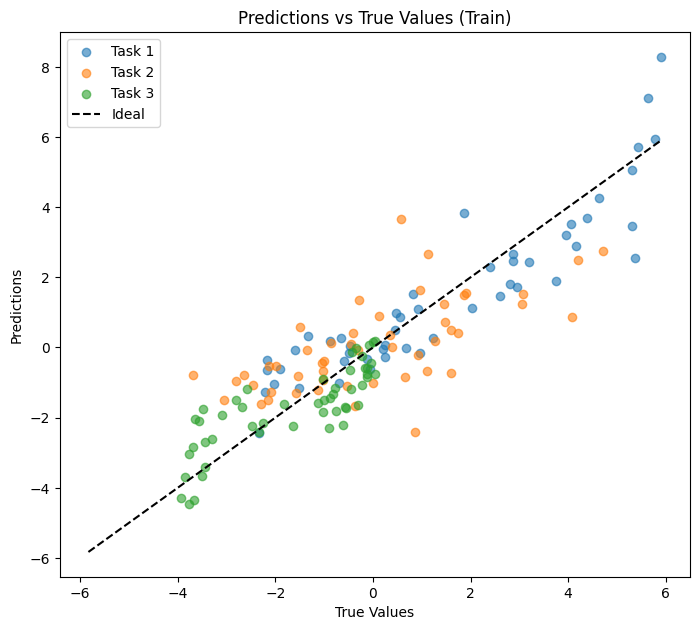

Dependent Mean tanh results: {'avg_test_mse': 1.6338928046229175, 'success_rate': 1.0}


In [16]:
# Запуск симуляции с обработкой возможных ошибок
try:
    dependent_mean_results = run_simulations(
        n_simulations=1, 
        activation='tanh', 
        with_plot=True,
        n_tasks=10,
        n_input=5,
        n_hidden=4,
        n_features=3
    )
    print(f"Dependent Mean tanh results: {dependent_mean_results}")
except Exception as e:
    print(f"Simulation failed with error: {str(e)}")


Simulation 1/1
Test MSE: 4.1569


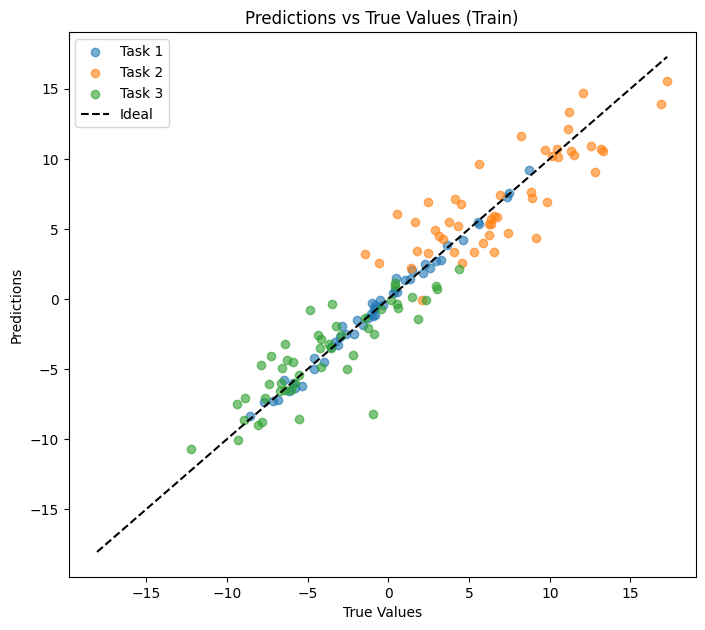

Dependent Mean linear results: {'avg_test_mse': 4.156867577153546, 'success_rate': 1.0}


In [17]:
# Запуск симуляции с обработкой возможных ошибок
try:
    dependent_mean_results = run_simulations(
        n_simulations=1, 
        activation='linear', 
        with_plot=True,
        n_tasks=10,
        n_input=5,
        n_hidden=4,
        n_features=3
    )
    print(f"Dependent Mean linear results: {dependent_mean_results}")
except Exception as e:
    print(f"Simulation failed with error: {str(e)}")

# Clustering of Tasks

In [19]:
from MultiTask_Algo import MultiTaskNNClustering

In [20]:
def generate_clustered_data(n_tasks=10, n_samples_train=50, n_samples_test=300,
                            n_input=5, n_hidden=4, n_clusters=2, activation='tanh'):
    # True parameters with clear cluster separation
    true_W = np.random.randn(n_hidden, n_input + 1) * 0.5

    # Create distinct cluster centers
    cluster_centers = np.random.randn(n_clusters, n_hidden + 1) * 2
    for i in range(n_clusters):
        cluster_centers[i] += i * 3  # Separate clusters

    # Assign tasks to clusters
    true_z = np.zeros((n_tasks, n_clusters))
    for i in range(n_tasks):
        true_z[i, i % n_clusters] = 1

    # Generate data for each task
    train_data = []
    test_data = []

    for i in range(n_tasks):
        # Generate covariates
        X_train = np.random.randn(n_samples_train, n_input)
        X_test = np.random.randn(n_samples_test, n_input)

        # Scale per task
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Compute hidden activations
        X_train_bias = np.hstack([X_train, np.ones((n_samples_train, 1))])
        X_test_bias = np.hstack([X_test, np.ones((n_samples_test, 1))])

        if activation == 'tanh':
            h_train = np.tanh(np.dot(X_train_bias, true_W.T))
            h_test = np.tanh(np.dot(X_test_bias, true_W.T))
        else:
            h_train = np.dot(X_train_bias, true_W.T)
            h_test = np.dot(X_test_bias, true_W.T)

        # Add bias term
        h_train = np.hstack([h_train, np.ones((n_samples_train, 1))])
        h_test = np.hstack([h_test, np.ones((n_samples_test, 1))])

        # Get cluster for this task
        cluster_idx = np.argmax(true_z[i])

        # Generate task weights from cluster distribution
        A = np.random.multivariate_normal(
            cluster_centers[cluster_idx],
            np.eye(n_hidden + 1) * 0.1
        )

        # Generate responses
        y_train = np.dot(h_train, A) + np.random.randn(n_samples_train) * 0.1
        y_test = np.dot(h_test, A) + np.random.randn(n_samples_test) * 0.1

        train_data.append((X_train, y_train))
        test_data.append((X_test, y_test))

    return train_data, test_data, true_z

In [21]:
def evaluate_clustering_model(model, test_data):
    mse = 0
    for i, (X_test, y_test) in enumerate(test_data):
        y_pred = model.predict(X_test, i)
        mse += np.mean((y_test - y_pred) ** 2)
    mse /= len(test_data)

    return {
        'test_mse': mse,
        'cluster_assignments': model.get_cluster_assignments(),
        'task_similarity': model.get_task_similarity()
    }

In [22]:
def plot_clustering_results(model, X_list, y_list):
    plt.figure(figsize=(20, 15))

    # 1. Predictions vs True (first 3 tasks)
    plt.subplot(3, 3, 1)
    global_min = min(np.min(y) for y in y_list)
    global_max = max(np.max(y) for y in y_list)

    for i in range(min(3, len(X_list))):
        y_pred = model.predict(X_list[i], i)
        plt.scatter(y_list[i], y_pred, alpha=0.6, label=f'Task {i + 1}')
    plt.plot([global_min, global_max], [global_min, global_max], 'k--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Predictions vs True Values')
    plt.legend()

    # 2. Cluster assignments
    #plt.subplot(3, 3, 2)
    #assignments = model.get_cluster_assignments()
    #plt.hist(assignments, bins=model.n_clusters, rwidth=0.8)
    #plt.xlabel('Cluster')
    #plt.ylabel('Number of Tasks')
    #plt.title('Task Cluster Assignments')

    # 3. Task similarity matrix
    #plt.subplot(3, 3, 3)
    #similarity = model.get_task_similarity()
    #plt.imshow(similarity, cmap='Blues', interpolation='nearest')
    #plt.colorbar()
    #plt.title('Task Similarity Matrix')

    # 4. Cluster centers visualization
    #plt.subplot(3, 3, 4)
    #for cluster in range(model.n_clusters):
    #    plt.plot(model.m[cluster], label=f'Cluster {cluster + 1}')
    #plt.xlabel('Weight Index')
    #plt.ylabel('Value')
    #plt.title('Cluster Centers (m)')
    #plt.legend()

    # 5. Cluster probabilities (q)
    #plt.subplot(3, 3, 5)
    #plt.bar(range(model.n_clusters), model.q)
    #plt.xlabel('Cluster')
    #plt.ylabel('Probability')
    #plt.title('Cluster Probabilities (q)')

    # 6. First two dimensions of A weights colored by cluster
    #plt.subplot(3, 3, 6)
    #colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k'][:model.n_clusters]
    #for i, A in enumerate(model.A_map):
    #    cluster = assignments[i]
    #    plt.scatter(A[0], A[1], color=colors[cluster], alpha=0.6)
    #plt.xlabel('A[0]')
    #plt.ylabel('A[1]')
    #plt.title('A Weights Colored by Cluster')

    # 7. Shared weights W
    #plt.subplot(3, 3, 7)
    #plt.imshow(model.W, aspect='auto', cmap='coolwarm')
    #plt.colorbar()
    #plt.title('Shared Weights W')

    # 8. Cluster responsibilities (z)
    #plt.subplot(3, 3, 8)
    #plt.imshow(model.z.T, aspect='auto', cmap='viridis')
    #plt.colorbar()
    #plt.xlabel('Task')
    #plt.ylabel('Cluster')
    #plt.title('Cluster Responsibilities')

    plt.tight_layout()
    plt.show()

In [23]:
def run_clustering_simulation(n_simulations=1, activation='tanh', with_plot=False,
                              n_tasks=10, n_input=5, n_hidden=4, n_clusters=2):
    results = []

    for sim in range(n_simulations):
        print(f"\nSimulation {sim + 1}/{n_simulations}")

        try:
            # Generate clustered data
            train_data, test_data, true_z = generate_clustered_data(
                n_tasks=n_tasks, n_input=n_input, n_hidden=n_hidden,
                n_clusters=n_clusters, activation=activation
            )

            # Initialize model
            model = MultiTaskNNClustering(
                n_input=n_input,
                n_hidden=n_hidden,
                n_tasks=n_tasks,
                n_clusters=n_clusters,
                activation=activation
            )

            X_list = [X for X, y in train_data]
            y_list = [y for X, y in train_data]

            # Fit model
            model.fit(train_data, max_iter=100)

            # Evaluate
            metrics = evaluate_clustering_model(model, test_data)
            results.append(metrics)

            print(f"Test MSE: {metrics['test_mse']:.4f}")
            #print(f"Cluster assignments: {metrics['cluster_assignments']}")

            if with_plot:
                plot_clustering_results(model, X_list, y_list)

        except Exception as e:
            print(f"Error in simulation {sim + 1}: {str(e)}")
            continue

    if not results:
        print("Warning: All simulations failed")
        return None

    return {
        'avg_test_mse': np.mean([r['test_mse'] for r in results]),
        'cluster_consistency': np.mean([
            np.mean(r['cluster_assignments'] == np.array([i % n_clusters for i in range(n_tasks)]))
            for r in results
        ])
    }


Simulation 1/1


100%|██████████| 100/100 [02:51<00:00,  1.72s/it]


Test MSE: 0.0487


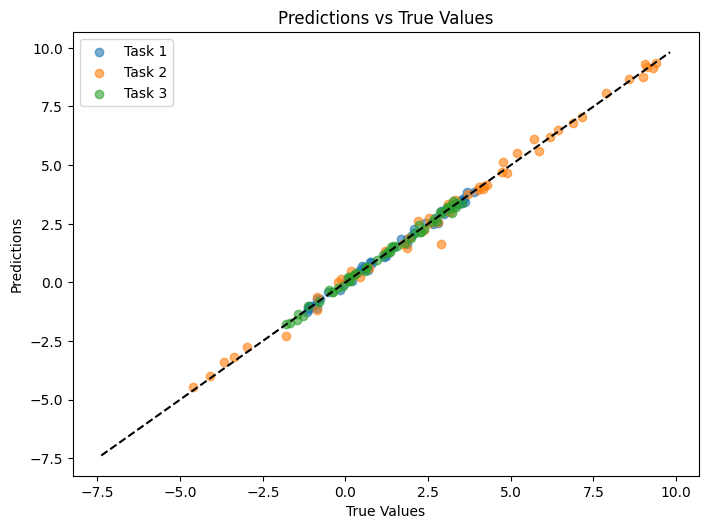

In [24]:
# Run simulation with visualization
clustering_results = run_clustering_simulation(
    n_simulations=1,
    activation='tanh',
    with_plot=True,
    n_tasks=10,
    n_input=5,
    n_hidden=4,
    n_clusters=2
)

In [25]:
print("\nFinal Results tanh:")
print(f"Average Test MSE: {clustering_results['avg_test_mse']:.4f}")
#print(f"Cluster Consistency: {clustering_results['cluster_consistency']:.2%}")


Final Results tanh:
Average Test MSE: 0.0487



Simulation 1/1


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


Test MSE: 0.0114


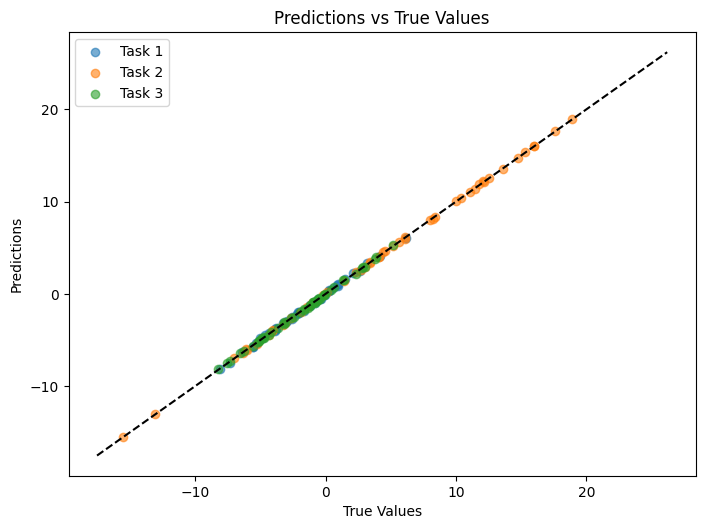

In [26]:
# Run simulation with visualization
clustering_results = run_clustering_simulation(
    n_simulations=1,
    activation='linear',
    with_plot=True,
    n_tasks=10,
    n_input=5,
    n_hidden=4,
    n_clusters=2
)

In [27]:
print("\nFinal Results linear:")
print(f"Average Test MSE: {clustering_results['avg_test_mse']:.4f}")
#print(f"Cluster Consistency: {clustering_results['cluster_consistency']:.2%}")


Final Results linear:
Average Test MSE: 0.0114


# Gating of Tasks

In [37]:
from MultiTask_Algo import MultiTaskNNGating

In [38]:
def generate_gating_data(n_tasks=10, n_samples_train=50, n_samples_test=300,
                         n_input=5, n_hidden=4, n_clusters=2, n_features=3, activation='tanh'):
    # True parameters with clear cluster separation
    true_W = np.random.randn(n_hidden, n_input + 1) * 0.5

    # Create distinct cluster centers
    cluster_centers = np.random.randn(n_clusters, n_hidden + 1) * 2
    for i in range(n_clusters):
        cluster_centers[i] += i * 3  # Separate clusters

    # Generate task features that correlate with cluster assignments
    true_U = np.random.randn(n_clusters, n_features) * 1.5
    task_features = np.random.randn(n_tasks, n_features)

    # Assign tasks to clusters based on features
    logits = np.dot(task_features, true_U.T)
    true_z = softmax(logits, axis=1)

    # Generate data for each task
    train_data = []
    test_data = []

    for i in range(n_tasks):
        # Generate covariates
        X_train = np.random.randn(n_samples_train, n_input)
        X_test = np.random.randn(n_samples_test, n_input)

        # Scale per task
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Compute hidden activations
        X_train_bias = np.hstack([X_train, np.ones((n_samples_train, 1))])
        X_test_bias = np.hstack([X_test, np.ones((n_samples_test, 1))])

        if activation == 'tanh':
            h_train = np.tanh(np.dot(X_train_bias, true_W.T))
            h_test = np.tanh(np.dot(X_test_bias, true_W.T))
        else:
            h_train = np.dot(X_train_bias, true_W.T)
            h_test = np.dot(X_test_bias, true_W.T)

        # Add bias term
        h_train = np.hstack([h_train, np.ones((n_samples_train, 1))])
        h_test = np.hstack([h_test, np.ones((n_samples_test, 1))])

        # Get cluster for this task
        cluster_idx = np.argmax(true_z[i])

        # Generate task weights from cluster distribution
        A = np.random.multivariate_normal(
            cluster_centers[cluster_idx],
            np.eye(n_hidden + 1) * 0.1
        )

        # Generate responses
        y_train = np.dot(h_train, A) + np.random.randn(n_samples_train) * 0.1
        y_test = np.dot(h_test, A) + np.random.randn(n_samples_test) * 0.1

        train_data.append((X_train, y_train))
        test_data.append((X_test, y_test))

    return train_data, test_data, task_features, true_z

In [39]:
def evaluate_gating_model(model, test_data, true_z):
    mse = 0
    for i, (X_test, y_test) in enumerate(test_data):
        y_pred = model.predict(X_test, i)
        mse += np.mean((y_test - y_pred) ** 2)
    mse /= len(test_data)

    # Compute clustering accuracy
    true_assignments = np.argmax(true_z, axis=1)
    pred_assignments = model.get_cluster_assignments()
    clustering_acc = np.mean(true_assignments == pred_assignments)

    return {
        'test_mse': mse,
        'clustering_accuracy': clustering_acc,
        'cluster_assignments': pred_assignments,
        'task_similarity': model.get_task_similarity(),
        'true_z': true_z,
        'pred_z': model.z
    }

In [40]:
def plot_gating_results(model, X_list, y_list, task_features, true_z):
    plt.figure(figsize=(24, 16))

    # 1. Predictions vs True (first 3 tasks)
    plt.subplot(3, 4, 1)
    global_min = min(np.min(y) for y in y_list)
    global_max = max(np.max(y) for y in y_list)

    for i in range(min(3, len(X_list))):
        y_pred = model.predict(X_list[i], i)
        plt.scatter(y_list[i], y_pred, alpha=0.6, label=f'Task {i + 1}')
    plt.plot([global_min, global_max], [global_min, global_max], 'k--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Predictions vs True Values')
    plt.legend()

    # 2. True vs Predicted cluster assignments
    # plt.subplot(3, 4, 2)
    # true_assign = np.argmax(true_z, axis=1)
    # pred_assign = model.get_cluster_assignments()
    # plt.scatter(true_assign, pred_assign, alpha=0.6)
    # plt.xlabel('True Cluster')
    # plt.ylabel('Predicted Cluster')
    # plt.title('Cluster Assignment Accuracy')

    # 3. Gating network weights (U)
    # plt.subplot(3, 4, 3)
    # plt.imshow(model.U, aspect='auto', cmap='coolwarm')
    # plt.colorbar()
    # plt.title('Gating Network Weights (U)')

    # 4. Cluster centers visualization
    # plt.subplot(3, 4, 4)
    # for cluster in range(model.n_clusters):
    #    plt.plot(model.m[cluster], label=f'Cluster {cluster+1}')
    # plt.xlabel('Weight Index')
    # plt.ylabel('Value')
    # plt.title('Cluster Centers (m)')
    # plt.legend()

    # 5. True vs Predicted responsibilities
    # plt.subplot(3, 4, 5)
    # plt.scatter(true_z[:,0], model.z[:,0], alpha=0.6)
    # plt.xlabel('True Responsibility Cluster 0')
    # plt.ylabel('Predicted Responsibility Cluster 0')
    # plt.title('Cluster Responsibilities Comparison')

    # 6. Task features colored by true cluster
    # plt.subplot(3, 4, 6)
    # true_assign = np.argmax(true_z, axis=1)
    # for i in range(model.n_clusters):
    #    mask = true_assign == i
    #    plt.scatter(task_features[mask,0], task_features[mask,1],
    #               label=f'True Cluster {i}', alpha=0.6)
    # plt.xlabel('Feature 1')
    # plt.ylabel('Feature 2')
    # plt.title('Task Features (True Clusters)')
    # plt.legend()

    # 7. Task features colored by predicted cluster
    # plt.subplot(3, 4, 7)
    # pred_assign = model.get_cluster_assignments()
    # for i in range(model.n_clusters):
    #    mask = pred_assign == i
    #    plt.scatter(task_features[mask,0], task_features[mask,1],
    #               label=f'Pred Cluster {i}', alpha=0.6)
    # plt.xlabel('Feature 1')
    # plt.ylabel('Feature 2')
    # plt.title('Task Features (Predicted Clusters)')
    # plt.legend()

    # 8. Shared weights W
    # plt.subplot(3, 4, 8)
    # plt.imshow(model.W, aspect='auto', cmap='coolwarm')
    # plt.colorbar()
    # plt.title('Shared Weights W')

    # 9. Cluster responsibilities (z)
    # plt.subplot(3, 4, 9)
    # plt.imshow(model.z.T, aspect='auto', cmap='viridis')
    # plt.colorbar()
    # plt.xlabel('Task')
    # plt.ylabel('Cluster')
    # plt.title('Cluster Responsibilities (z)')

    # 10. True responsibilities
    # plt.subplot(3, 4, 10)
    # plt.imshow(true_z.T, aspect='auto', cmap='viridis')
    # plt.colorbar()
    # plt.xlabel('Task')
    # plt.ylabel('Cluster')
    # plt.title('True Responsibilities')

    plt.tight_layout()
    plt.show()

In [41]:
def run_gating_simulation(n_simulations=1, activation='tanh', with_plot=False,
                          n_tasks=10, n_input=5, n_hidden=4,
                          n_clusters=2, n_features=3):
    results = []

    for sim in range(n_simulations):
        print(f"\nSimulation {sim + 1}/{n_simulations}")

        try:
            # Generate data with task features
            train_data, test_data, task_features, true_z = generate_gating_data(
                n_tasks=n_tasks, n_input=n_input, n_hidden=n_hidden,
                n_clusters=n_clusters, n_features=n_features, activation=activation
            )

            # Initialize model
            model = MultiTaskNNGating(
                n_input=n_input,
                n_hidden=n_hidden,
                n_tasks=n_tasks,
                n_clusters=n_clusters,
                n_features=n_features,
                activation=activation
            )

            X_list = [X for X, y in train_data]
            y_list = [y for X, y in train_data]

            # Fit model
            model.fit(train_data, task_features, max_iter=100)

            # Evaluate
            metrics = evaluate_gating_model(model, test_data, true_z)
            results.append(metrics)

            print(f"Test MSE: {metrics['test_mse']:.4f}")
            # print(f"Clustering Accuracy: {metrics['clustering_accuracy']:.2%}")

            if with_plot:
                plot_gating_results(model, X_list, y_list, task_features, true_z)

        except Exception as e:
            print(f"Error in simulation {sim + 1}: {str(e)}")
            continue

    if not results:
        print("Warning: All simulations failed")
        return None

    return {
        'avg_test_mse': np.mean([r['test_mse'] for r in results]),
        'avg_clustering_acc': np.mean([r['clustering_accuracy'] for r in results])
    }


Simulation 1/1
Error at iteration 0: index 1 is out of bounds for axis 1 with size 1
Test MSE: 1.6658


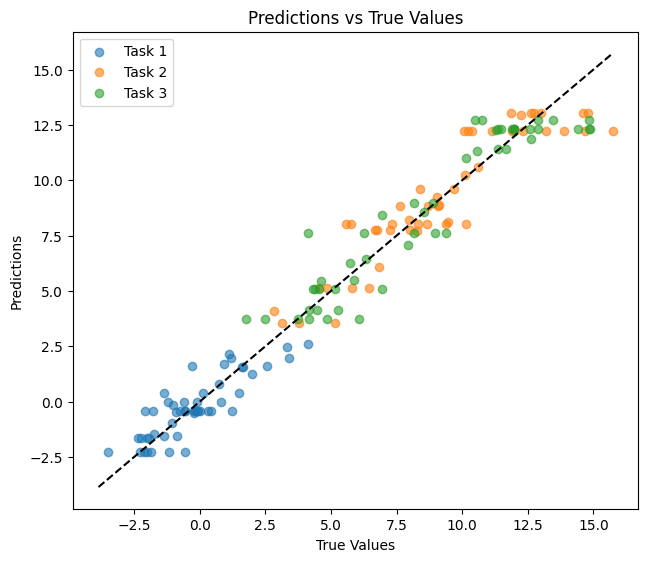

In [42]:
# Run simulation with visualization
gating_results = run_gating_simulation(
    n_simulations=1,
    activation='tanh',
    with_plot=True,
    n_tasks=10,
    n_input=5,
    n_hidden=4,
    n_clusters=2,
    n_features=3
)

In [43]:
print("\nFinal Results tanh:")
print(f"Average Test MSE: {gating_results['avg_test_mse']:.4f}")
# print(f"Average Clustering Accuracy: {gating_results['avg_clustering_acc']:.2%}")


Final Results tanh:
Average Test MSE: 1.6658



Simulation 1/1


/kaggle/input/multitask/MultiTask_Algo1.py:788: RuntimeWarning: overflow encountered in exp
  sigma = np.exp(log_sigma)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


Iteration 0, log likelihood: 489460511471.92786
Error at iteration 1: index 1 is out of bounds for axis 1 with size 1
Test MSE: 0.0111


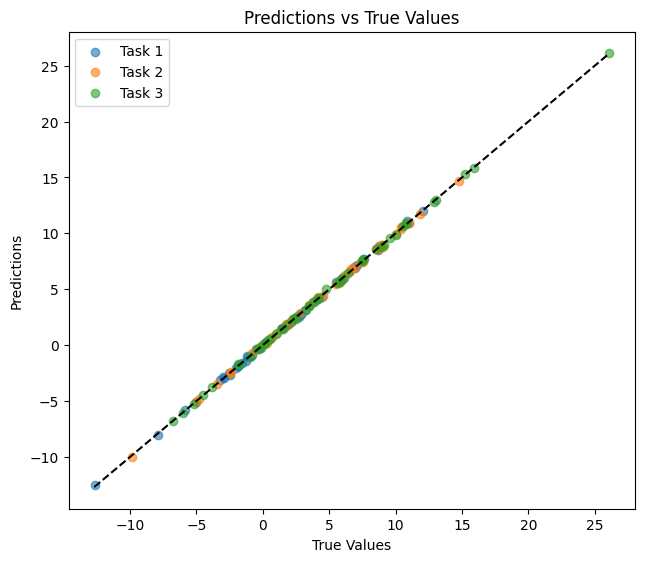

In [44]:
# Run simulation with visualization
gating_results = run_gating_simulation(
    n_simulations=1,
    activation='linear',
    with_plot=True,
    n_tasks=10,
    n_input=5,
    n_hidden=4,
    n_clusters=2,
    n_features=3
)

In [45]:
print("\nFinal Results linear:")
print(f"Average Test MSE: {gating_results['avg_test_mse']:.4f}")
# print(f"Average Clustering Accuracy: {gating_results['avg_clustering_acc']:.2%}")


Final Results linear:
Average Test MSE: 0.0111
